In [ ]:
# Purpose of the code:
    # Create a regression model to predict MSFC scores/change in scores
        # Model: Lasso
        # Validation: 10-fold cross validation

In [134]:
# necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [135]:
# switch to the proper directory to access the data
cd /camdatalake/bronze/verily_ms/device/

/camdatalake/bronze/verily_ms/device


In [136]:
# download and read the data

# FeatureDay: Average value of the features for each day of study. Days are listed as 
# DayOfStudy

# FeatureStudy: Features for the entire study period.For the at home features, 
# the reported value is the median of the observed day level values.

import gzip, csv
with gzip.open("FeaturesDay.csv.gz", "rt", newline="") as file:
    FeatureDay = pd.read_csv(file, header = 0)

with gzip.open("FeaturesStudy.csv.gz", "rt", newline="") as file:
    FeatureStudy = pd.read_csv(file, header = 0)

In [137]:
# explore the datasets
FeatureDay.shape

(1532, 217)

In [138]:
FeatureStudy.shape

(25, 216)

In [139]:
def filter_dataFrame(df):
    # a function to return sensor related features in the original dataframe (df)
    Selected_features = []
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    Selected_features.append('gls_subject_code')
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    # free living features(20 columns)
    # extracted before in Data_Visualization_Part_1_FeatureStudy_Correlation_of_Sensor_Features_to_MSFC.py, and saved
    df_free_living_related = pd.read_csv('FeatureStudy_free_living_related')
    df_free_living_col_names = list(df_free_living_related.columns)
    # add everything to Selected_features list
    Selected_features += list(df_free_living_related.columns)
    Selected_features += df_at_home_col_names
    Selected_features += df_columns_MSFC_col_names
    # return filtered df with selected features
    return df[Selected_features]

In [140]:
def filter_dataFrame_fillna(df):
    # a function to fill null values in the input dataframe (df)
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    df_columns_patientID_col_names =['gls_subject_code']
    df_patientID= df[df_columns_patientID_col_names]
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    df_msfcComposite = df[df_columns_MSFC_col_names]
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    df_structuredActivity_atHome = df[df_at_home_col_names]
    # free living features(20 columns)
    df_all_except_freeLiving_col_names = df_columns_patientID_col_names + df_columns_MSFC_col_names + df_at_home_col_names
    df_free_living_col_names = list(set(df_columns_names) - set(df_all_except_freeLiving_col_names))
    df_freeLiving = df[df_free_living_col_names]
    
    # fill null values by row for df_msfcComposite
    for idx in range(len(df_msfcComposite.index)):
        df_msfcComposite.iloc[idx].fillna(df_msfcComposite.iloc[idx].mean(), inplace = True)
    # fill null values by column for df_structuredActivity_atHome
    for col_name in list(df_structuredActivity_atHome.columns):
        df_structuredActivity_atHome[col_name].fillna(df_structuredActivity_atHome[col_name].mean(),inplace= True)
    # fill null values by column for df_freeLiving
    for col_name in list(df_freeLiving.columns):
        df_freeLiving[col_name].fillna(df_freeLiving[col_name].mean(),inplace= True)
    
    # return filtered dataframe with selected features
    return pd.concat([df_patientID,df_freeLiving,df_structuredActivity_atHome,df_msfcComposite],axis=1)

In [141]:
def remove_rows_with_null(df,TH):
    # remove rows with in df with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum(axis=1)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(idx)
    df_filtered = df.drop(indexes)
    # return the updated dataframe
    return df_filtered.reset_index(drop=True)

In [142]:
def remove_columns_with_null(df,TH):
    # remove columns with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum()
    col_labels = list(count_null.index)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(col_labels[idx])
    df_filtered = df.drop(indexes, axis=1)
    # return the updated dataframe
    return df_filtered.reset_index(drop=True)

In [143]:
def bin_scores(val,num_of_bins, minimum, maximum):
     # a function to bin the scores
    # input: 
        # val: input value to bin
        # num_of_bins: desired number of bins
        # minimum & maximum: specify the range of values
    # output:
        # binned value
    step = (maximum - minimum)/num_of_bins
    curr_val = minimum
    level = 1
    while(curr_val < maximum):
        curr_val += step
        if val <= curr_val:
            return level
        else:
            level += 1

In [144]:
# extract part of the original dataset which is related to sensor measurements
FeatureStudy_filtered = filter_dataFrame(FeatureStudy)
FeatureDay_filtered = filter_dataFrame(FeatureDay)

In [145]:
#######################################################RESHAPE FEATURESDAY#########################################

In [ ]:
# to consider the time component, we take pair of (feature_value, day_of_study) as a new feature

In [146]:
# check the original dataset
FeatureDay_filtered.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,-1.211435,-1.385647,-1.40763
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,-1.211435,-1.385647,-1.40763
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,-1.211435,-1.385647,-1.40763
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,-1.211435,-1.385647,-1.40763
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,-1.211435,-1.385647,-1.40763


In [147]:
# drop composite scores, we do not have any varoius values for them over days
FeatureDay_filtered_device_features = FeatureDay_filtered.drop(['msfc_composite_1','msfc_composite_2','msfc_composite_3'],axis=1)
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_lr_at_home,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,424.878675,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,460.529853,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,371.773641,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,408.234556,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,380.493350,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555


(1532, 61)

In [148]:
# will need days of study as an index, add to the dataset
FeatureDay_filtered_device_features['dayofstudy'] = FeatureDay['dayofstudy']
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


(1532, 62)

In [149]:
# extract patient IDs
patientIDs = FeatureDay_filtered['gls_subject_code'].unique()
patientIDs

array(['H800001', 'H800002', 'H800003', 'H800004', 'H800006', 'H800007',
       'H800008', 'H800009', 'H800010', 'H800011', 'H800013', 'H800014',
       'H800016', 'H800017', 'H800018', 'H800019', 'H800020', 'H800021',
       'H800022', 'H800023', 'H800024', 'H800025', 'H800005', 'H800012',
       'H800015'], dtype=object)

In [150]:
# what is the maximum number of study days for patients?
num_of_days_of_study = [FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].shape[0] for ID in patientIDs]
days_of_study = pd.DataFrame()
days_of_study['patientID'] = patientIDs
days_of_study['num_of_days'] = num_of_days_of_study
days_of_study.head()
max_num_of_days = max(days_of_study['num_of_days'])

,patientID,num_of_days
0,H800001,62
1,H800002,63
2,H800003,68
3,H800004,65
4,H800006,79


In [151]:
# device features dataset + patient IDs + day of study + composite scores
FeatureDay_filtered_device_features.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


In [152]:
# just keep the sensor feature values
device_feature_names = list(FeatureDay_filtered_device_features.drop(['gls_subject_code','dayofstudy'],axis = 1))
len(device_feature_names)

60

In [153]:
# transform the dataset, add feature values for day x as a new column
final_df = pd.DataFrame()
for ID in patientIDs:
    print(ID)
    arr = ID.split('0')
    sub_df = FeatureDay_filtered_device_features[FeatureDay_filtered_device_features['gls_subject_code'] == ID]
    new_df = pd.DataFrame()
    new_df['gls_subject_code'] = [ID]
    for day in np.arange(1,max_num_of_days + 1):
        for feature in device_feature_names:
            col_name = feature + '_day_' + str(day)
            if day in sub_df['dayofstudy'].tolist():
                idx = sub_df['dayofstudy'].tolist().index(23)
                val = sub_df.iloc[idx][feature]
                new_df[col_name] = [val]
            else:
                new_df[col_name] = [np.nan]
    final_df = pd.concat([final_df,new_df])

H800001
H800002
H800003
H800004
H800006
H800007
H800008
H800009
H800010
H800011
H800013
H800014
H800016
H800017
H800018
H800019
H800020
H800021
H800022
H800023
H800024
H800025
H800005
H800012
H800015


In [154]:
# check the transformed dataframe
final_df.head()
final_df.shape

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,sway_disp_lr_at_home_day_80,sway_disp_ap_at_home_day_80,mobility_activity_at_home_time_day_80,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(25, 4801)

In [155]:
# add back patient IDs + composite scores to the transformed dataset
msfc_composite_1 = []
msfc_composite_2 = []
msfc_composite_3 = []
for ID in final_df['gls_subject_code']:
    msfc_composite_1.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_1'])
    msfc_composite_2.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_2'])
    msfc_composite_3.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_3'])
final_df['msfc_composite_1'] = msfc_composite_1
final_df['msfc_composite_2'] = msfc_composite_2
final_df['msfc_composite_3'] = msfc_composite_3
final_df.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [156]:
# fix the index of the transformed dataset
FeatureDay_filtered_reshaped = final_df.reset_index(drop=True)
FeatureDay_filtered_reshaped.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
1,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
2,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
3,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
4,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [157]:
#####################################################END OF RESHAPING FEATUREDAY######################################################

In [158]:
# preprocessing: remove columns, rows with > 50% null values

# feature study
# column
TH = FeatureStudy_filtered.shape[0]/2
FeatureStudy_filtered_nullDropped = remove_columns_with_null(FeatureStudy_filtered, TH)
# row
TH = FeatureStudy_filtered.shape[1]/2
FeatureStudy_filtered_nullDropped = remove_rows_with_null(FeatureStudy_filtered_nullDropped, TH)

# feature day
# column
TH = FeatureDay_filtered_reshaped.shape[0]/2
FeatureDay_filtered_reshaped_nullDropped = remove_columns_with_null(FeatureDay_filtered_reshaped, TH)
# row
TH = FeatureDay_filtered_reshaped_nullDropped.shape[1]/2
FeatureDay_filtered_reshaped_nullDropped = remove_rows_with_null(FeatureDay_filtered_reshaped_nullDropped, TH)

# compare shapes of new data frames with original ones
FeatureStudy_filtered.shape
FeatureStudy_filtered_nullDropped.shape
FeatureDay_filtered_reshaped.shape
FeatureDay_filtered_reshaped_nullDropped.shape

(25, 64)

(22, 64)

(25, 4804)

(20, 1830)

In [159]:
# preprocessing: fill null values
# msfc composite scores: mean on row
# feature values: mean on columns
df_study = filter_dataFrame_fillna(FeatureStudy_filtered_nullDropped)
df_day = filter_dataFrame_fillna(FeatureDay_filtered_reshaped_nullDropped)

/opt/python3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [160]:
# check to make sure there is no null value left
df_day.shape
df_day.isnull().sum().sum()
df_study.shape
df_study.isnull().sum().sum()

(20, 1830)

0

(22, 64)

0

In [161]:
# data engineering: add msfc3-msfc2 to the datasets
# there are three potential targets to predict: msfc_composite_3, msfc_change, msfc_composite_3_bin
df_study['msfc_change'] = df_study['msfc_composite_3'] - df_study['msfc_composite_2']
df_day['msfc_change'] = df_day['msfc_composite_3'] - df_day['msfc_composite_2']

In [162]:
# data engineering: add binned msfc3 scores to the dataset
num_of_bins = 3
minimum =  df_study['msfc_composite_3'].min()
maximum = df_study['msfc_composite_3'].max()
df_study['msfc_composite_3_bin'] = df_study['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

num_of_bins = 3
minimum =  df_day['msfc_composite_3'].min()
maximum = df_day['msfc_composite_3'].max()
df_day['msfc_composite_3_bin'] = df_day['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

In [163]:
# msfc1 and msfc2 are both included mong features
# prepare x,y
# df_study
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_study = df_study.drop(col_names_potential_targets,axis=1)
y_study_score = df_study['msfc_composite_3']
y_study_scoreChange = df_study['msfc_change']
# normalize data
from sklearn import preprocessing
x_study_scaled = pd.DataFrame(preprocessing.normalize(x_study),columns=x_study.columns)

In [164]:
# prepare x,y
# df_day
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_day = df_day.drop(col_names_potential_targets,axis=1)
y_day_score = df_day['msfc_composite_3']
y_day_scoreChange = df_day['msfc_change']
# normalize data
from sklearn import preprocessing
x_day_scaled = pd.DataFrame(preprocessing.normalize(x_day),columns=x_day.columns)

In [174]:
# model prediction, include msfc2 & msfc1 as features
# LassoCV 
# it will automatically look for the best alpha and do the cross validation
train_data = []
target = []
alphas = []
selected_features = []
coefficients = []
MSEs = []
model_complexity = []
model_complexity_unique = []
num_of_samples = []
num_of_features = []

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


{'duration_movement_count': 3.4342607319232138e-09,
 'mobility_activity_at_home_time': -1.3727683782510722e-05,
 'mobility_stance_at_home': -0.45233265214990481,
 'movement_rate': -0.013811662794888479,
 'msfc_composite_1': 0.4077747417789509,
 'msfc_composite_2': 0.30857687815319518,
 'turn_vel_std_ankle': 0.0033892832018009565}

,selected_features
0,turn_vel_std_ankle
1,duration_movement_count
2,movement_rate
3,mobility_stance_at_home
4,mobility_activity_at_home_time
5,msfc_composite_1
6,msfc_composite_2


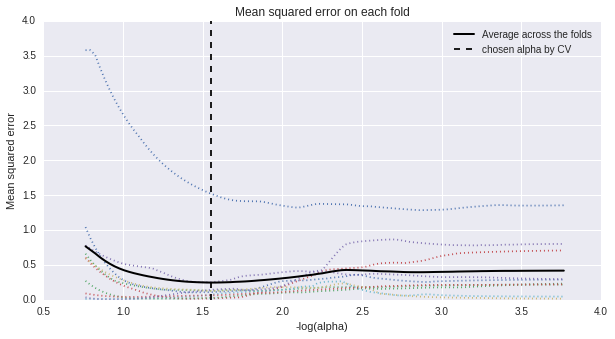

In [175]:
# train data: feature study(normalized)
# target: msfc3 
# validation: 10-fold cross validation

# train the model, 10 fold cross validation
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_study
y = y_study_score
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k, scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the data into a dataframe
train_data.append('FeatureStudy')
target.append('msfc3')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(coeffs))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = features
feature_df

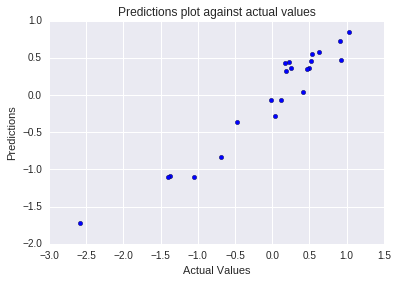

In [98]:
# train data: feature study(normalized)
# target: msfc3 
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

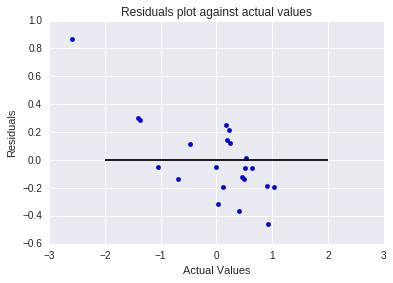

In [99]:
# train data: feature study(normalized)
# target: msfc3 
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


{'fatigue_level_at_home_day_1': -0.041491758161062077,
 'hourly_amb_temp_range_at_home_day_59': -0.0059796754176091368,
 'hourly_amb_temp_range_at_home_day_60': -0.0013614050186303542,
 'hourly_temp_median_at_home_day_1': 0.052105669359207643,
 'hourly_temp_range_at_home_day_1': -0.47273888106440104,
 'hourly_temp_range_at_home_day_10': -1.9590732265771908e-10,
 'hourly_temp_range_at_home_day_11': -2.8795732890706521e-11,
 'hourly_temp_range_at_home_day_12': -4.23223728691391e-12,
 'hourly_temp_range_at_home_day_13': -6.2236474357066831e-13,
 'hourly_temp_range_at_home_day_14': -9.1417293045567665e-14,
 'hourly_temp_range_at_home_day_15': -1.3651762270036026e-14,
 'hourly_temp_range_at_home_day_16': -1.7825098922534087e-15,
 'hourly_temp_range_at_home_day_17': -5.4465580041076374e-16,
 'hourly_temp_range_at_home_day_18': -2.1220355860159626e-16,
 'hourly_temp_range_at_home_day_19': -2.2635046250836936e-16,
 'hourly_temp_range_at_home_day_2': -0.025317343132123662,
 'hourly_temp_range_a

,selected_features
0,turn_angle_ankle
1,hourly_temp_median_at_home
2,mean_pvt_delay_3_at_home
3,msfc_composite_2
4,hourly_temp_range_at_home
5,mean_pvt_delay_7_at_home
6,turn_vel_mean
7,idle_minutes
8,fatigue_level_at_home
9,hourly_temp_std_at_home


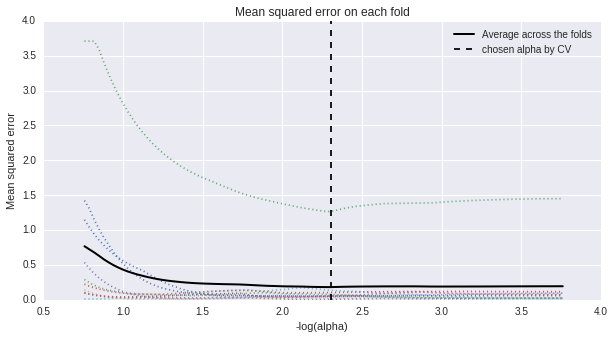

In [176]:
# train data: feature day(normalized)
# target: msfc3
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_day
y = y_day_score
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureDay')
target.append('msfc3')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(list(set([feature.split('_day_')[0] for feature in features]))))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = list(set([feature.split('_day_')[0] for feature in features]))
feature_df

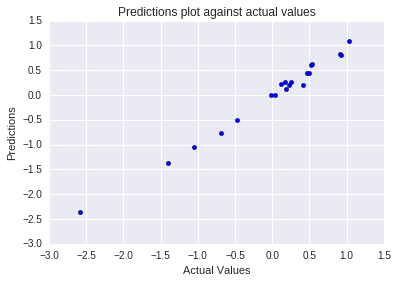

In [101]:
# train data: feature day(normalized)
# target: msfc3
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

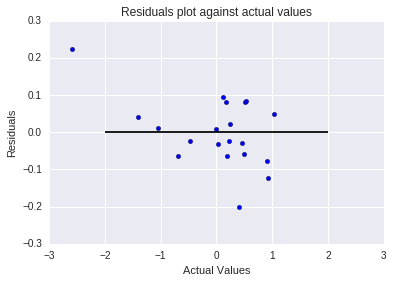

In [102]:
# train data: feature day(normalized)
# target: msfc3
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to i

{'duration_rem_count': 1.6771914588624822e-20}

,selected_features
0,duration_rem_count


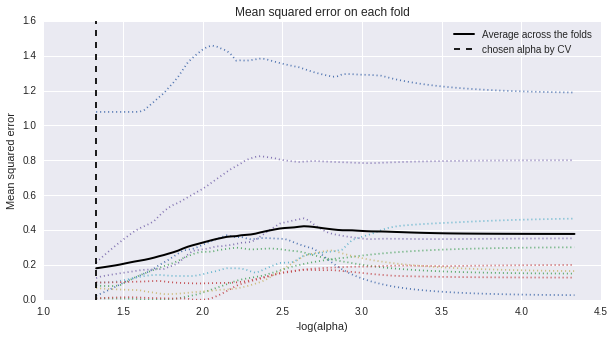

In [177]:
# train data: feature study(normalized)
# target: msfc3 - msfc2
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_study
y = y_study_scoreChange
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureStudy')
target.append('msfc3 - msfc2')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(coeffs))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = features
feature_df

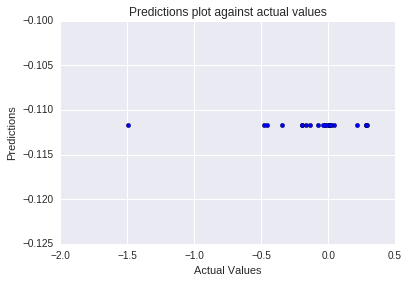

In [104]:
# train data: feature study(normalized)
# target: msfc3 - msfc2
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

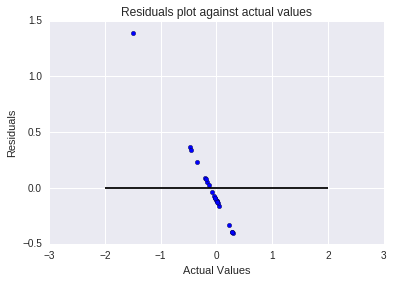

In [105]:
# train data: feature study(normalized)
# traget: msfc3 - msfc2
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


{'hourly_amb_temp_range_at_home_day_59': -0.0043267395599548173,
 'hourly_amb_temp_range_at_home_day_60': -0.00040550711742894357,
 'hourly_temp_median_at_home_day_1': 0.090256491094423144,
 'hourly_temp_median_at_home_day_10': 3.591749666605705e-12,
 'hourly_temp_median_at_home_day_11': 2.8569853620505279e-13,
 'hourly_temp_median_at_home_day_12': 2.2729014399662764e-14,
 'hourly_temp_median_at_home_day_13': 1.8065793410163242e-15,
 'hourly_temp_median_at_home_day_14': 1.4286680096631448e-16,
 'hourly_temp_median_at_home_day_15': 1.0241969935616713e-17,
 'hourly_temp_median_at_home_day_16': 1.0415562646389878e-18,
 'hourly_temp_median_at_home_day_17': 1.9095198185048109e-18,
 'hourly_temp_median_at_home_day_18': 6.9437084309265851e-19,
 'hourly_temp_median_at_home_day_19': 6.9437084309265851e-19,
 'hourly_temp_median_at_home_day_2': 0.00056171452714279821,
 'hourly_temp_median_at_home_day_20': 6.9437084309265851e-19,
 'hourly_temp_median_at_home_day_21': 6.9437084309265851e-19,
 'hour

,selected_features
0,stance
1,turn_angle_ankle
2,hourly_temp_median_at_home
3,mean_pvt_delay_3_at_home
4,turn_vel_std
5,walk_minutes
6,turn_vel_std_ankle
7,turn_angle
8,mean_pvt_delay_7_at_home
9,hourly_temp_range_at_home


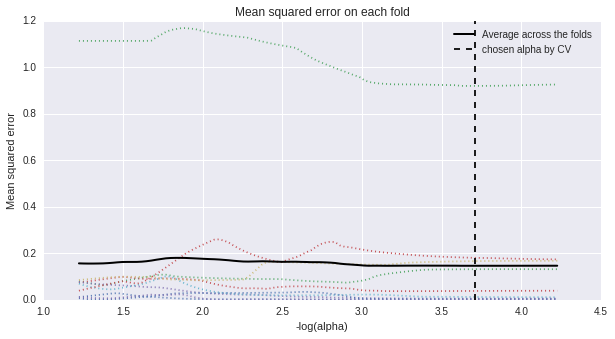

In [178]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_day
y = y_day_scoreChange
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureDay')
target.append('msfc3 - msfc2')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(list(set([feature.split('_day_')[0] for feature in features]))))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = list(set([feature.split('_day_')[0] for feature in features]))
feature_df

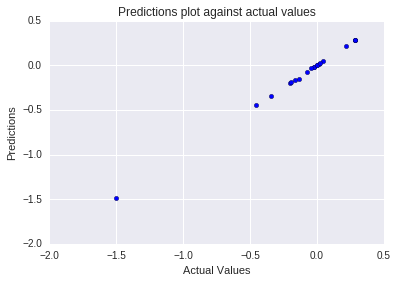

In [107]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

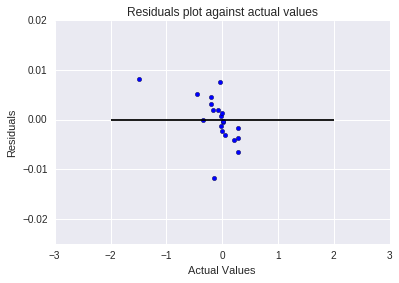

In [108]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

In [109]:
summary = pd.DataFrame()
summary['train_data'] = train_data
summary['num_of_samples'] = num_of_samples
summary['num_of_features'] = num_of_features
summary['target'] = target
summary['alphas'] = alphas
summary['MSEs'] = MSEs
summary['model_complexity'] = model_complexity
summary['model_complexity_unique'] = model_complexity_unique
summary

,train_data,num_of_samples,num_of_features,target,alphas,MSEs,model_complexity,model_complexity_unique
0,FeatureStudy,22,62,msfc3,0.027964,0.550589,7,7
1,FeatureDay,20,1828,msfc3,0.004961,0.156124,89,12
2,FeatureStudy,22,62,msfc3 - msfc2,0.046528,0.202976,1,1
3,FeatureDay,20,1828,msfc3 - msfc2,0.000195,0.178833,202,15


(0, 2)

(0, 2)

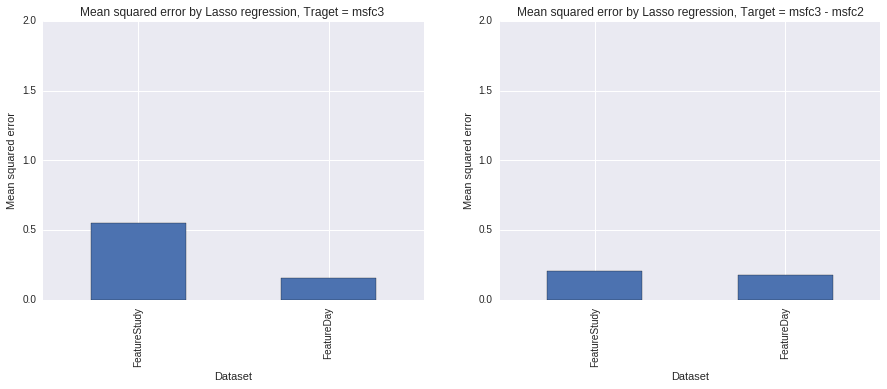

In [110]:
# visualize the resulted mean squared errors
figs, axes = plt.subplots(nrows= 1, ncols= 2)

axes[0] = summary.set_index('train_data')['MSEs'].iloc[[0,1]].plot(kind='bar',ax=axes[0],figsize=(15,5))
axes[0].set_title('Mean squared error by Lasso regression, Traget = msfc3 ')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean squared error')
axes[0].set_ylim((0,2))

axes[1] = summary.set_index('train_data')['MSEs'].iloc[[2,3]].plot(kind='bar',ax=axes[1])
axes[1].set_title('Mean squared error by Lasso regression, Target = msfc3 - msfc2')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Mean squared error')
axes[1].set_ylim((0,2))

In [179]:
# repeat but this time eleminate msfc2 and msfc1 as features

In [180]:
# prepare x,y
# df_study
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin', 'msfc_composite_1', 'msfc_composite_2']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_study = df_study.drop(col_names_potential_targets,axis=1)
y_study_score = df_study['msfc_composite_3']
y_study_scoreChange = df_study['msfc_change']
# normalize data
from sklearn import preprocessing
x_study_scaled = pd.DataFrame(preprocessing.normalize(x_study),columns=x_study.columns)

In [181]:
# prepare x,y
# df_day
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin', 'msfc_composite_1', 'msfc_composite_2']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_day = df_day.drop(col_names_potential_targets,axis=1)
y_day_score = df_day['msfc_composite_3']
y_day_scoreChange = df_day['msfc_change']
# normalize data
from sklearn import preprocessing
x_day_scaled = pd.DataFrame(preprocessing.normalize(x_day),columns=x_day.columns)

In [182]:
# model prediction, include msfc2 & msfc1 as features
# LassoCV 
# it will automatically look for the best alpha and do the cross validation
train_data = []
target = []
alphas = []
selected_features = []
coefficients = []
MSEs = []
model_complexity = []
model_complexity_unique = []
num_of_samples = []
num_of_features = []

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

{'mobility_stance_at_home': -0.25005716208378609,
 'pq_nondominant_median_at_home': -0.00091094320823943622}

,selected_features
0,pq_nondominant_median_at_home
1,mobility_stance_at_home


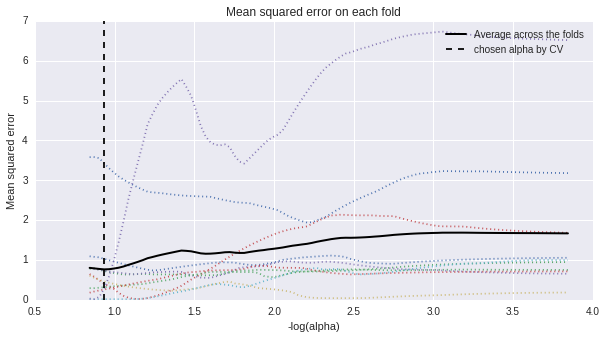

In [183]:
# train data: feature study(normalized)
# target: msfc3 
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_study
y = y_study_score
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k, scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the data into a dataframe
train_data.append('FeatureStudy')
target.append('msfc3')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(coeffs))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = features
feature_df

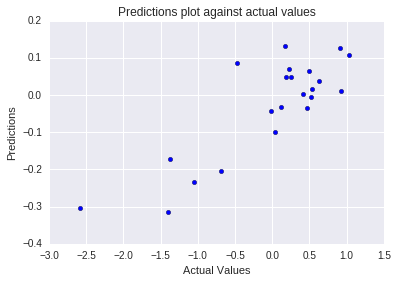

In [116]:
# train model: feature study(normalized)
# target: msfc3 
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

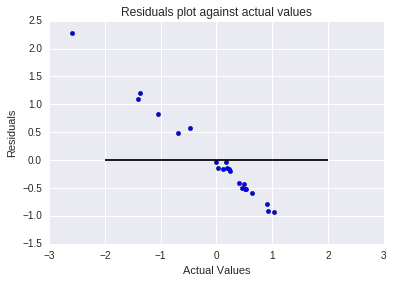

In [117]:
# train model: feature study(normalized)
# target: msfc3 
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


{'fatigue_level_at_home_day_1': -0.15094163583140099,
 'fatigue_level_at_home_day_2': -0.00037269759239601518,
 'fatigue_level_at_home_day_3': -0.00013812298079189173,
 'hourly_amb_temp_median_at_home_day_1': -0.0087517939026793071,
 'hourly_amb_temp_median_at_home_day_2': -0.00012749636580543558,
 'hourly_temp_range_at_home_day_1': -0.085641398196912355,
 'hourly_temp_range_at_home_day_2': -0.024368338198672727,
 'hourly_temp_range_at_home_day_3': -3.6821384906554897e-05,
 'hourly_temp_range_at_home_day_4': -2.4922531246331152e-06,
 'mean_pvt_delay_7_at_home_day_1': -0.0014286812156394666,
 'mean_pvt_delay_7_at_home_day_2': -2.0043997462922721e-05,
 'mean_pvt_delay_7_at_home_day_3': -1.1337076337795658e-06,
 'mean_pvt_delay_7_at_home_day_4': -3.2077920253713304e-09,
 'mean_pvt_delay_7_at_home_day_5': -4.7150301278622145e-10,
 'mean_pvt_delay_7_at_home_day_6': -1.7690928376911113e-12,
 'mean_pvt_delay_7_at_home_day_7': -2.7194758640736079e-16,
 'mean_pvt_delay_7_at_home_day_8': -5.0082

,selected_features
0,turn_vel_std_ankle
1,mean_pvt_delay_7_at_home
2,turn_duration_ankle
3,hourly_temp_range_at_home
4,hourly_amb_temp_median_at_home
5,fatigue_level_at_home
6,turn_duration


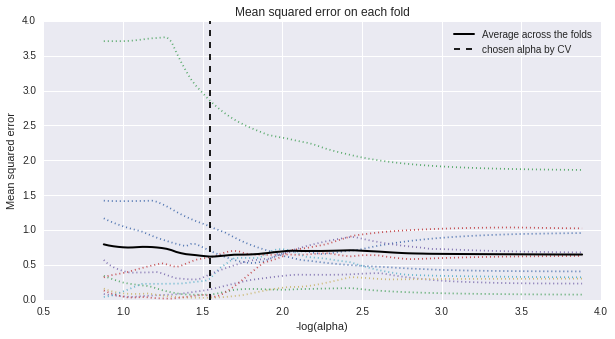

In [184]:
# train model: feature day(normalized)
# target: msfc3
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_day
y = y_day_score
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureDay')
target.append('msfc3')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(list(set([feature.split('_day_')[0] for feature in features]))))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = list(set([feature.split('_day_')[0] for feature in features]))
feature_df

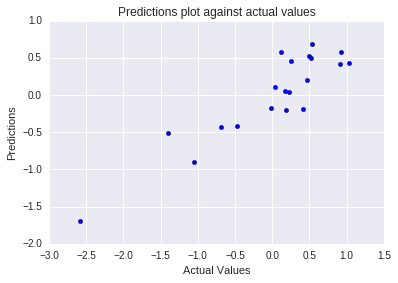

In [119]:
# train data: feature day(normalized)
# target: msfc3
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

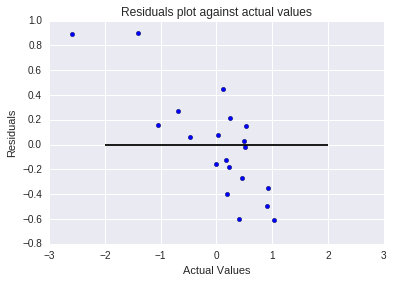

In [120]:
# train data: feature day(normalized)
# target: msfc3
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


{'duration_rem_count': 1.6771914588624822e-20}

,selected_features
0,duration_rem_count


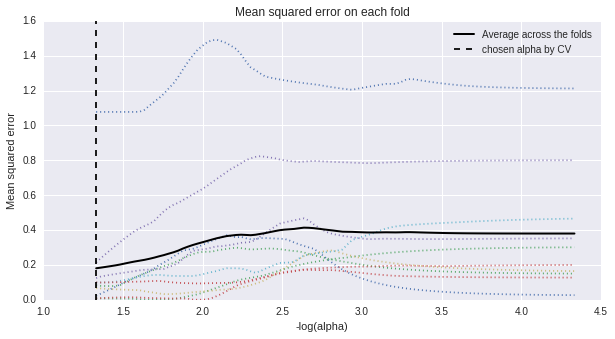

In [185]:
# train data: feature study(normalized)
# target: msfc3 - msfc2
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_study
y = y_study_scoreChange
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureStudy')
target.append('msfc3 - msfc2')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(coeffs))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = features
feature_df

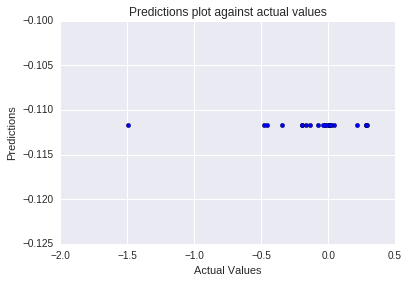

In [122]:
# train data: feature study(normalized)
# target: msfc3 - msfc2
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

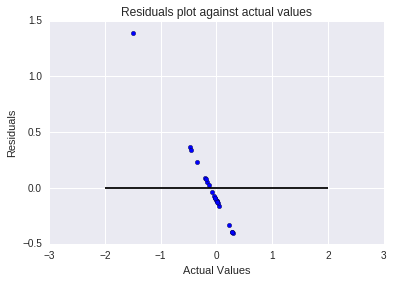

In [123]:
# train data: feature study(normalized)
# target: msfc3 - msfc2
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to i

{'duration_movement_count_day_17': -2.3778325888474454e-12,
 'duration_movement_count_day_22': -1.296770305886888e-12,
 'duration_movement_count_day_24': -7.0287570778890306e-13,
 'duration_movement_count_day_25': -1.5294624730259153e-26,
 'duration_movement_count_day_31': -4.4354411717751543e-25,
 'duration_movement_count_day_33': -3.7468372473627177e-11,
 'duration_movement_count_day_43': -7.5913160541622163e-11,
 'duration_movement_count_day_55': -3.0589249460518306e-26,
 'hourly_amb_temp_range_at_home_day_59': -0.0053498724588794651,
 'hourly_temp_median_at_home_day_1': 0.091916368110577296,
 'hourly_temp_range_at_home_day_1': -0.43189988383447753,
 'hourly_temp_range_at_home_day_10': -6.2552374891970678e-05,
 'hourly_temp_range_at_home_day_11': -6.0649224979331438e-05,
 'hourly_temp_range_at_home_day_12': -8.1562769878684623e-05,
 'hourly_temp_range_at_home_day_13': -9.213636880111561e-05,
 'hourly_temp_range_at_home_day_14': -8.701610324533342e-05,
 'hourly_temp_range_at_home_day

,selected_features
0,stance
1,turn_angle_ankle
2,hourly_temp_median_at_home
3,mean_pvt_delay_3_at_home
4,turn_vel_std
5,walk_minutes
6,mean_pvt_delay_at_home
7,turn_vel_std_ankle
8,turn_duration_ankle
9,turn_angle


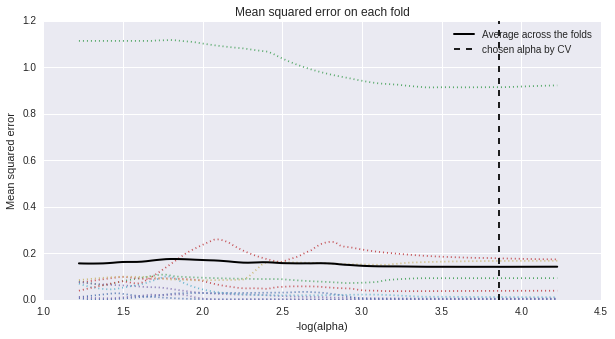

In [186]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# validation: 10-fold cross validation

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV
x = x_day
y = y_day_scoreChange
k = 10

lasso = LassoCV(cv=k,random_state=42,normalize=True)  
lasso.fit(x,y)
scores = cross_val_score(lasso, x, y, cv=k,scoring='mean_squared_error')

# plot mean square error for each fold
model = lasso
m_log_alphascv = -np.log10(model.alphas_)
plt.figure(figsize=(10,5))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='chosen alpha by CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
# print variable names and regression coefficients
features = []
coeffs = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        coeffs.append(lasso.coef_[i])
        features.append(list(x.columns)[i])
dict(zip(features, coeffs))

# save the results into a dataframe
train_data.append('FeatureDay')
target.append('msfc3 - msfc2')
alphas.append(lasso.alpha_)
selected_features.append(features)
coefficients.append(coeffs)
MSEs.append(abs(scores).mean())
model_complexity.append(len(coeffs))
num_of_samples.append(len(y))
num_of_features.append(x.shape[1])
model_complexity_unique.append(len(list(set([feature.split('_day_')[0] for feature in features]))))

# print out a table of selected features
feature_df = pd.DataFrame()
feature_df['selected_features'] = list(set([feature.split('_day_')[0] for feature in features]))
feature_df

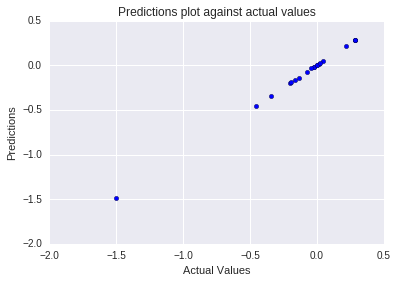

In [125]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# plot predictions against actual values
plt.scatter(y.tolist(), lasso.predict(x))
plt.title('Predictions plot against actual values')
plt.ylabel('Predictions')
plt.xlabel('Actual Values')

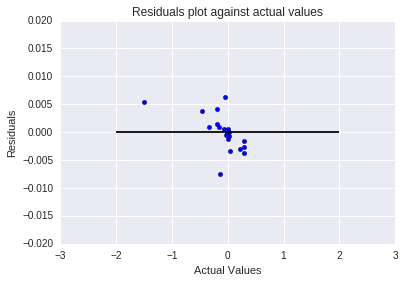

In [126]:
# train data: feature day(normalized)
# target: msfc3 - msfc2
# plot residuals against actual values
residuals = [i-j for i,j in zip(lasso.predict(x), y.tolist())]
plt.scatter(y.tolist(), residuals)
plt.hlines(y=0,xmin=-2, xmax=2)
plt.title('Residuals plot against actual values')
plt.ylabel('Residuals')
plt.xlabel('Actual Values')

In [127]:
summary = pd.DataFrame()
summary['train_data'] = train_data
summary['num_of_samples'] = num_of_samples
summary['num_of_features'] = num_of_features
summary['target'] = target
summary['alphas'] = alphas
summary['MSEs'] = MSEs
summary['model_complexity'] = model_complexity
summary['model_complexity_unique'] = model_complexity_unique
summary

,train_data,num_of_samples,num_of_features,target,alphas,MSEs,model_complexity,model_complexity_unique
0,FeatureStudy,22,60,msfc3,0.116214,1.438485,2,2
1,FeatureDay,20,1826,msfc3,0.028395,0.659313,37,7
2,FeatureStudy,22,60,msfc3 - msfc2,0.046528,0.202976,1,1
3,FeatureDay,20,1826,msfc3 - msfc2,0.000138,0.175919,189,19


(0, 2)

(0, 2)

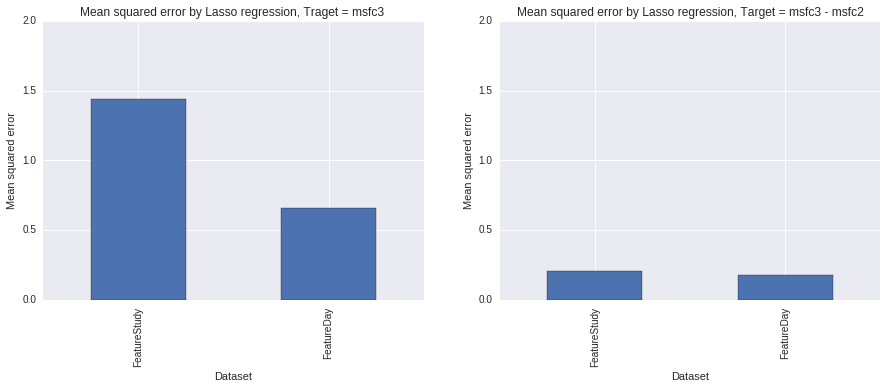

In [128]:
# visualize the resulted mean squared errors scores
figs, axes = plt.subplots(nrows= 1, ncols= 2)

axes[0] = summary.set_index('train_data')['MSEs'].iloc[[0,1]].plot(kind='bar',ax=axes[0],figsize=(15,5))
axes[0].set_title('Mean squared error by Lasso regression, Traget = msfc3 ')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean squared error')
axes[0].set_ylim((0,2))

axes[1] = summary.set_index('train_data')['MSEs'].iloc[[2,3]].plot(kind='bar',ax=axes[1])
axes[1].set_title('Mean squared error by Lasso regression, Target = msfc3 - msfc2')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Mean squared error')
axes[1].set_ylim((0,2))